# Predict survival

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import numpy as np

# reproducibility
np.random.seed(42)

In [2]:
# Load the dataset into a pandas DataFrame
data = pd.read_excel('./d1.xlsx')

# removing labels and unuseful col
data = data.drop('PatientCode',axis=1) 
data = data.drop('dos',axis=1) 
data = data.drop('dpfs',axis=1) 
data = data.drop('1stpfsevent',axis=1)
data = data.drop('oors',axis=1) 
# drop any rows with -99 value
data = data[~data.isin([-99]).any(axis=1)] 
#drop any rows with Nan value (only 1)
data = data.dropna()

print(len(data))

267


In [3]:
# split TR, TS
train, test = train_test_split(data, test_size=0.2, random_state=42)

# x, y split
# train
y_train = train["osevent"]
x_train = train.drop(['osevent'], axis=1)

# test
y_test = test["osevent"]
x_test = test.drop(['osevent'], axis=1)

# RFE (feature selection)

In [4]:
min_features_to_select = 1
# RFE
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    step=1, # number of feature to eliminate per iteration
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select
)
# fit
rfecv.fit(x_train, y_train)

# print optimal number of feature selected
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 7


In [5]:
# return the selected columns
x_train.columns[(rfecv.get_support())]

Index(['age @random', 'outcome of surgery', 'RTK_RAS', 'WNT', 'HIPPO',
       'CELL_CYCLE', 'TP53'],
      dtype='object')

In [15]:
rfecv.ranking_

array([19, 13, 47,  1, 14, 26, 12, 23, 24,  5,  6, 31, 20, 21, 17, 16, 22,
       29, 43, 40, 39,  7, 15, 34, 41, 38, 44, 36, 33, 25, 42, 28, 37, 48,
       45, 46, 35, 18, 30, 10,  9,  2,  1,  8,  1, 32,  3,  1,  1,  1, 27,
        4, 11,  1])

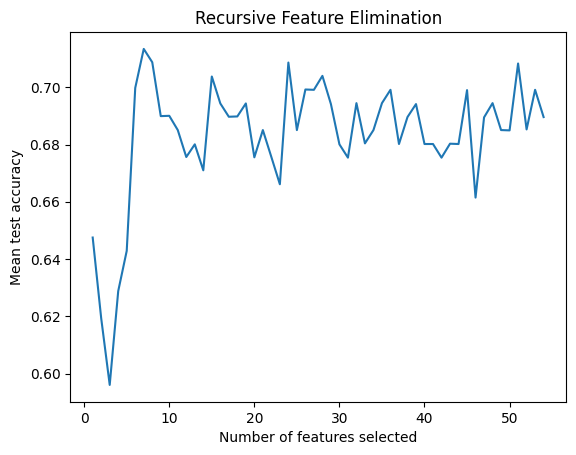

In [6]:
# Plot accuracy and number of features 

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    #yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [7]:
# print max result on validation set
max(rfecv.cv_results_["mean_test_score"])

0.7133997785160575

# Random forest prediction with selected data

In [8]:
# predict with RandomForestClassifier on selected features
y_pred = rfecv.predict(x_test)

# Accuracy of RF on Test

In [9]:
# compute accuracy
accuracy_score(y_test, y_pred)

0.7037037037037037

# Select data with relevant features

In [10]:
# data with only the selected features, converted automatically into narray
selected_x_train = rfecv.transform(x_train)
selected_x_test = rfecv.transform(x_test)

# KNN on selected data

In [11]:
# Grid search for KNN

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
 
# Creating the hyperparameter grid
param_grid = {'n_neighbors': [3,5,10,15,20],
              'weights': ['uniform','distance'],
              'metric': ['euclidean','minkowski','cosine']}

 
# Instantiating knn classifier
knn = KNeighborsClassifier()
 
# Instantiating the GridSearchCV object
knn_cv = GridSearchCV(knn, param_grid, cv = 5, refit=True)
 
knn_cv.fit(selected_x_train, y_train)
 
# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score on validation is {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best score on validation is 0.7466223698781839


# Model assesment

In [12]:
from sklearn.metrics import classification_report

# prediction
grid_predictions = knn_cv.predict(selected_x_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.43      0.40      0.41        15
           1       0.78      0.79      0.78        39

    accuracy                           0.69        54
   macro avg       0.60      0.60      0.60        54
weighted avg       0.68      0.69      0.68        54



In [13]:
#pickle.dump(knn_cv, open('KNN.pkl', 'wb'))
#pickle.dump(rfecv, open('rfecv_RF.pkl', 'wb'))

Feature: 0, Score: 0.21076
Feature: 1, Score: 0.12286
Feature: 2, Score: 0.14896
Feature: 3, Score: 0.15334
Feature: 4, Score: 0.10415
Feature: 5, Score: 0.13286
Feature: 6, Score: 0.12707


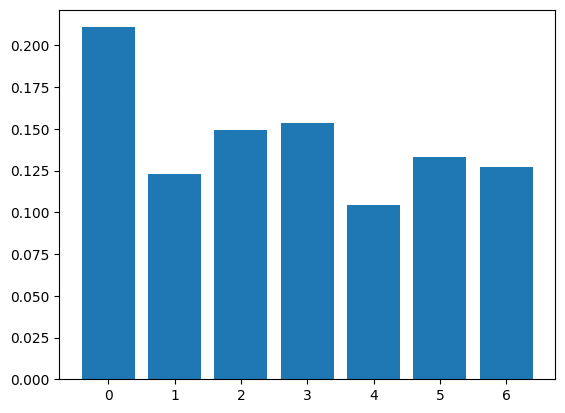

In [31]:
from matplotlib import pyplot
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(selected_x_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()